# Study 4: Amazon Mechanical Turk Subjective Ratings 

In [2]:
%matplotlib inline

from collections import OrderedDict
import warnings
import glob
import os
import json
import csv
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, ttest_ind, pearsonr
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

import statsmodels.formula.api as smf

from nltools.data import Adjacency
from nltools.stats import (fisher_r_to_z, 
                           downsample, 
                           threshold, 
                           upsample, 
                           zscore, 
                           pearson, 
                           align,
                           winsorize, 
                           fdr, 
                           regress,
                           isc)

from fnl_tools.stats import (sort_subject_clusters, 
                             calc_fft, 
                             validity_index, 
                             extract_max_timeseries,
                             create_avg_concordance,
                             calculate_r_square,
                             align_clusters_groups,
                             group_cluster_consensus
                            )
from fnl_tools.plotting import (plot_raster,
                                plot_recurrence,
                                plot_avg_state_timeseries,
                                plot_wavelet,
                                plot_concordance)
from fnl_tools.utils import get_rect_coord,rec_to_time
from fnl_tools.data import (create_emotion_df,
                            convert_data_from_database)

from emotioncf import create_sub_by_item_matrix
from emotioncf.cf import NNMF_sgd, Mean, KNN, NNMF_multiplicative

from pymer4.models import Lm, Lmer

warnings.filterwarnings('ignore')

base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'


/Users/lukechang/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/lukechang/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Process data from web app

In [3]:
convert_data_from_database(os.path.join(base_dir, 'Data', 'CollaborativeFiltering','query_result_2.csv'),
                           os.path.join(base_dir, 'Data', 'CollaborativeFiltering','sparse.json'))
file = open(os.path.join(base_dir, 'Data', 'CollaborativeFiltering','sparse.json'), 'r') 
ratings = json.loads(file.read())
print(ratings.keys())   

dict_keys(['Contempt', 'Surprise', 'Relief', 'Anger', 'Envy', 'Shame', 'Interest', 'Elation', 'Satisfaction', 'Guilt', 'Sadness', 'Hope', 'Pride', 'Fear', 'Joy', 'Disgust'])


# Metrics for paper

Participants: 171
Male: 94
Female: 67
Age Mean: 37.07
Age Stdev: 10.76

Everyone was paid $9
If we include a few more people who watched all four eps, including the first:
Participants: 175
Male: 96
Female: 67
Age Mean: 37.05
Age Stdev: 10.71

## Load Data

In [4]:
tr=2.
episode = 'ep01'
dilate_samples = 60
file = open(os.path.join(base_dir, 'Data', 'CollaborativeFiltering','sparse.json'), 'r') 
ratings = json.loads(file.read())
print(ratings.keys())
# name = list(ratings.keys())[14]
# dd = pd.read_csv(os.path.join(base_dir, 'Data', 'CollaborativeFiltering', f'FNL_EmotionCF_{name}_NNMF_SGD_Dilate{dilate_samples}_{version}.csv'), index_col=0)


dict_keys(['Contempt', 'Surprise', 'Relief', 'Anger', 'Envy', 'Shame', 'Interest', 'Elation', 'Satisfaction', 'Guilt', 'Sadness', 'Hope', 'Pride', 'Fear', 'Joy', 'Disgust'])


## Calculate number of trials per subject

In [12]:
n_sub = {}; n_trials = {}; n_trials_std = {};
for name in ratings:
    n_sub[name] = len(ratings[name])
    sub_trials = {}
    for sub in ratings[name]:
        sub_trials[sub] = len(ratings[name][sub])
    n_trials[name] = np.mean([sub_trials[x] for x in sub_trials])
    n_trials_std[name] = np.std([sub_trials[x] for x in sub_trials])
print('Mean Subjects: %s' % np.mean([n_sub[x] for x in n_sub]))
print('Mean Trials per Subject: %s' % np.mean([n_trials[x] for x in n_trials]))
print('Std Trials per Subject: %s' % np.mean([n_trials_std[x] for x in n_trials_std]))

Mean Subjects: 192.0
Mean Trials per Subject: 11.453125
Std Trials per Subject: 1.9251327402826885


## Calculate Rating intervals

In [13]:
name = list(ratings.keys())[0]
n_sec_mn = {}
n_sec_std = {}
for sub in ratings[name]:
    time_stamp = np.concatenate([np.zeros(1),np.array(np.sort([int(x) for x in list(ratings[name][sub].keys())]))])
    n_sec_mn[sub] = np.mean(np.diff(time_stamp))
    n_sec_std[sub] = np.std(np.diff(time_stamp))

print(f'Mean Trial Interval (sec): {np.mean([n_sec_mn[x] for x in n_sec_mn])}' )
print(f'Mean Trial Interval STD (sec): {np.mean([n_sec_std[x] for x in n_sec_mn])}')
    

Mean Trial Interval (sec): 229.6469615020396
Mean Trial Interval STD (sec): 53.32692552088659


# Run Collaborative Filtering with non negative matrix factorization

In [ ]:
file = open(os.path.join(base_dir, 'Data', 'CollaborativeFiltering','sparse.json'), 'r') 
ratings = json.loads(file.read())

for dilate_samples in [30,60]:
    for name in ratings.keys():
        dat = create_emotion_df(ratings, name=name)
        cf = NNMF_sgd(dat)
        cf.fit(n_iterations = 100,
             user_fact_reg=1.0,
             item_fact_reg=0.001,
             user_bias_reg=0,
             item_bias_reg=0,
             learning_rate=.001,
             dilate_ts_n_samples=dilate_samples)
        cf.predict()
        cf.predicted_ratings.to_csv(os.path.join(base_dir, 'Data', 'CollaborativeFiltering', f'FNL_EmotionCF_{name}_NNMF_SGD_Dilate{dilate_samples}_{version}.csv'))
        
        # Calculate Mean 
        cf2 = Mean(dat)
        cf2.fit(dilate_ts_n_samples=dilate_samples)
        cf2.predict()
        cf2.predicted_ratings.to_csv(os.path.join(base_dir, 'Data', 'CollaborativeFiltering', f'FNL_EmotionCF_{name}_Mean_Dilate{dilate_samples}_{version}.csv'))
        
        print(cf.get_mse('training'), cf2.get_mse('training'))

        # Write Summary to File
        summary = pd.DataFrame()
        summary['Subject'] = cf.ratings.index
        summary.index = cf.ratings.index
        summary['Emotion'] = name
        summary['Samples'] = cf.train_mask.sum(axis=1)
        summary['NNMF_Sub_MSE'] = cf.get_sub_mse('training')
        summary['NNMF_MSE'] = cf.get_mse('training')
        summary['Mean_Sub_MSE'] = cf2.get_sub_mse('training')
        summary['Mean_MSE'] = cf2.get_mse('training')
        summary.to_csv(os.path.join(base_dir, 'Data', 'CollaborativeFiltering', f'FNL_EmotionCF_{name}_NNMF_SGD_Dilate{dilate_samples}_Summary_{version}.csv'))

## Plot Model Summary Data

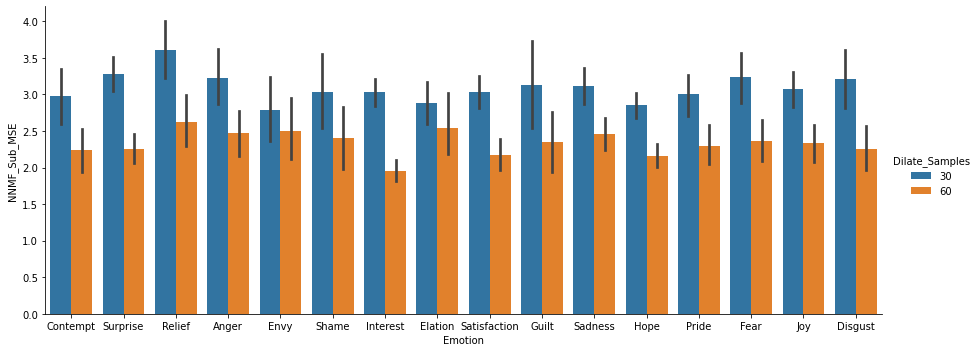

In [4]:
version = 'v3'
data = []
for dilate_samples in [30,60]:
    for name in ratings.keys():
        tmp = pd.read_csv(os.path.join(base_dir, 'Data', 'CollaborativeFiltering', 'FNL_EmotionCF_%s_NNMF_SGD_Dilate%s_Summary_%s.csv' % (name, dilate_samples, version)), index_col=0)
        tmp['Dilate_Samples'] = dilate_samples
        data.append(tmp)
data = pd.concat(data)

# f,a = plt.subplots(nrows=1, figsize=(15, 5))
sns.catplot(data=data, x='Emotion', y='NNMF_Sub_MSE', hue='Dilate_Samples', kind='bar', aspect=2.5)

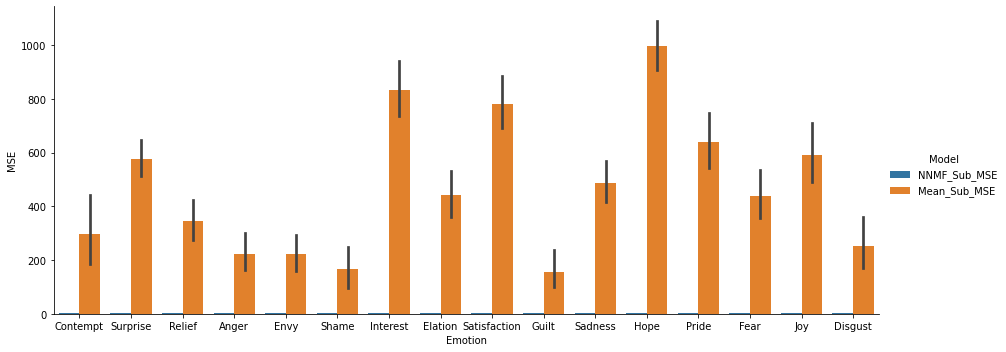

In [5]:
dilate_samples = 60
nnmf_v_mean = data.loc[data['Dilate_Samples'] == dilate_samples].melt(id_vars=['Subject', 'Emotion', 'Samples'], value_vars=['NNMF_Sub_MSE', 'Mean_Sub_MSE'], var_name='Model', value_name='MSE')
sns.catplot(data=nnmf_v_mean, x='Emotion', y='MSE', hue='Model', kind='bar', aspect=2.5)


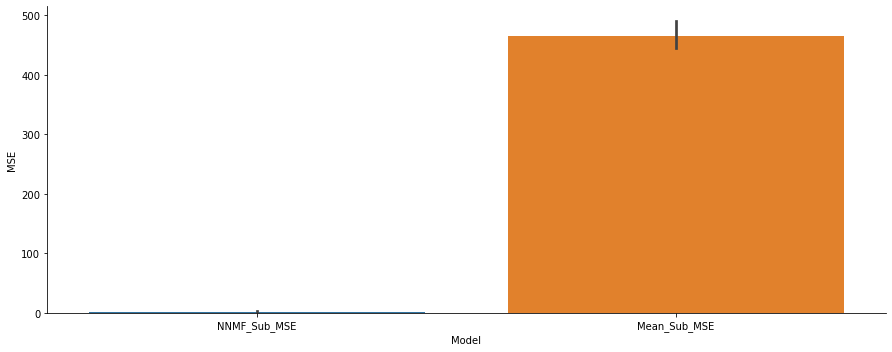

In [6]:
sns.catplot(data=nnmf_v_mean, x='Model', y='MSE', kind='bar', aspect=2.5)


# Find ratings that predict State Concordance separately for each study using PCR
- zscoring all features - this may be overweighting low rated items. switching to centering.
- repeating concordance for each subject
- n=192

In [4]:
cf_version = 'v3'
dilate_samples = 60
target_var = .9
study='study2'

roi = 32
brain_version = 'v4'
analysis = f'HMM_Combined_{brain_version}'

zscore = lambda x: (x - np.mean(x, axis=0)) / np.std(x, axis=0)
center = lambda x: (x - np.mean(x, axis=0))

all_data = {}
for name in ratings.keys():
    all_data[name] = pd.read_csv(os.path.join(base_dir, 'Data', 'CollaborativeFiltering', f'FNL_EmotionCF_{name}_NNMF_SGD_Dilate{dilate_samples}_{cf_version}.csv'), index_col=0).T

sub_ratings = []
for sub in range(192):
    sub_ratings.append(downsample(pd.DataFrame(center(np.array([all_data[x].iloc[:, sub] for x in all_data]).T)), sampling_freq=1, target=.5, target_type='hz'))
sub_ratings = pd.concat(sub_ratings, axis=0)

pca = PCA(n_components=target_var)
reduced = pca.fit_transform(sub_ratings)
reduced = pd.DataFrame(reduced)
reduced['Subject'] = np.hstack([np.ones(1364)*x for x in range(192)])
reduced.rename(columns={x:f'c{x}' for x in reduced.columns[:-1]}, inplace=True)

# for k in range(3,26):
for k in [2, 23, 24, 25]:
    s1_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_study1_k{k}_ROI{roi}_{brain_version}.csv'), index_col=0)
    # s2_dat = pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_study2_k{k}_ROI{roi}_{brain_version}.csv'), index_col=0)

    s1_concordance = create_average_concordance(s1_dat)
    # s2_concordance = create_average_concordance(s2_dat)

    s1_concordance.columns = [f'S1_{x}' for x in s1_concordance.columns]
    # s2_concordance.columns = [f'S2_{x}' for x in s2_concordance.columns]

    # combined = pd.concat([s1_concordance, s2_concordance], axis=1)
    combined = pd.concat([s1_concordance] * 192)
    combined.reset_index(inplace=True, drop=True)
    combined = pd.concat([reduced, combined], axis=1)

    # Run Regression
    states = [f'S1_State_{x}' for x in range(k)]
    pca_emo_models = {}
    for s in states:
        print(s)
        model = Lmer(f'{s} ~ c0+c1+c2+c3+c4+c5+c6+c7+c8+c9+c10 + (1|Subject)', data=combined)
        model.fit()
        pca_emo_models[s] = model
        
        
    # Plot Regression Results
    with sns.plotting_context(context='paper', font_scale=2):
        f,a = plt.subplots(ncols=k, figsize=(3*k, 6), sharex=True, sharey=True)
        for i,s in enumerate(states):
            pd.Series(pca.inverse_transform(pca_emo_models[s].coefs['Estimate'][1:].values), index=list(all_data.keys())).plot(kind='barh', legend=False, color='grey', ax=a[i])
    #         models[s].coefs['Estimate'].iloc[1:].plot(kind='barh', legend=False, color='grey', ax=a[i])
            a[i].set_title(s)
            a[i].set_xlabel('Rating', fontsize=18)
        a[0].yaxis.tick_left()

        plt.tight_layout()
        plt.savefig(os.path.join(base_dir,'Figures','RatingsStateRegression', f'Emotion_Rating_{study}_k{k}_roi{roi}_PCA.pdf'))
        plt.close()
        
    # Write out regression weights
    weights = {}
    for i,s in enumerate(states):
        weights[s] = pca.inverse_transform(pca_emo_models[s].coefs['Estimate'][1:].values)
    weights = pd.DataFrame(weights, index=list(all_data.keys()))
    weights.to_csv(os.path.join(base_dir,'Analyses','RatingsStateRegression', f'Emotion_Rating_{study}_k{k}_roi{roi}_PCA.csv'))

S1_State_0
boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c7+c8+c9+c10+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 261888	 Groups: {'Subject': 192.0}

Log-likelihood: 135786.789 	 AIC: -271573.578

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.021  0.144

No random effect correlations specified

Fixed effects:

S1_State_1
boundary (singular) fit: see ?isSingular 

Formula: S1_State_1~c0+c1+c2+c3+c4+c5+c6+c7+c8+c9+c10+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 261888	 Groups: {'Subject': 192.0}

Log-likelihood: 135786.789 	 AIC: -271573.578

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.021  0.144

No random effect correlations specified

Fixed effects:

S1_State_0
boundary (singular) fit: see ?isSingular 

Formula: S1_State_0~c0+c1+c2+c3+c4+c5+c6+c

boundary (singular) fit: see ?isSingular 

Formula: S1_State_17~c0+c1+c2+c3+c4+c5+c6+c7+c8+c9+c10+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 261888	 Groups: {'Subject': 192.0}

Log-likelihood: 388966.705 	 AIC: -777933.410

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.003  0.055

No random effect correlations specified

Fixed effects:

S1_State_18
boundary (singular) fit: see ?isSingular 

Formula: S1_State_18~c0+c1+c2+c3+c4+c5+c6+c7+c8+c9+c10+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 261888	 Groups: {'Subject': 192.0}

Log-likelihood: 364607.876 	 AIC: -729215.752

Random effects:

                 Name    Var   Std
Subject   (Intercept)  0.000  0.00
Residual               0.004  0.06

No random effect correlations specified

Fixed effects:

S1_State_19
boundary (singular) fit: see ?isSingular 

Formula: S1_State_19~c0+c1+c2+c3+c4+c5+c6+c7+c8+c9+c

boundary (singular) fit: see ?isSingular 

Formula: S1_State_13~c0+c1+c2+c3+c4+c5+c6+c7+c8+c9+c10+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 261888	 Groups: {'Subject': 192.0}

Log-likelihood: 380736.958 	 AIC: -761473.916

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.003  0.057

No random effect correlations specified

Fixed effects:

S1_State_14
boundary (singular) fit: see ?isSingular 

Formula: S1_State_14~c0+c1+c2+c3+c4+c5+c6+c7+c8+c9+c10+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 261888	 Groups: {'Subject': 192.0}

Log-likelihood: 361817.439 	 AIC: -723634.878

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.004  0.061

No random effect correlations specified

Fixed effects:

S1_State_15
boundary (singular) fit: see ?isSingular 

Formula: S1_State_15~c0+c1+c2+c3+c4+c5+c6+c7+c8+c

boundary (singular) fit: see ?isSingular 

Formula: S1_State_8~c0+c1+c2+c3+c4+c5+c6+c7+c8+c9+c10+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 261888	 Groups: {'Subject': 192.0}

Log-likelihood: 393883.964 	 AIC: -787767.928

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.003  0.054

No random effect correlations specified

Fixed effects:

S1_State_9
boundary (singular) fit: see ?isSingular 

Formula: S1_State_9~c0+c1+c2+c3+c4+c5+c6+c7+c8+c9+c10+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 261888	 Groups: {'Subject': 192.0}

Log-likelihood: 407069.583 	 AIC: -814139.166

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.000
Residual               0.003  0.051

No random effect correlations specified

Fixed effects:

S1_State_10
boundary (singular) fit: see ?isSingular 

Formula: S1_State_10~c0+c1+c2+c3+c4+c5+c6+c7+c8+c9+c